# PUBG Data Exploration + Random Forest (+ Funny GIFs)

[](http://)Hi fellow Kagglers! 

In this Kernel we ([Dalton Harmsen](https://www.kaggle.com/daltonharmsen), [Lourens Touwen](https://www.kaggle.com/lourenst) and [Carlo Lepelaars](https://www.kaggle.com/carlolepelaars)) will show you how we explore the [PUBG dataset](https://www.kaggle.com/c/pubg-finish-placement-prediction/data), detect outliers and recognize important features. We also implement a random forest model and optimize it.

If you like this Kaggle kernel, feel free to give an upvote and leave a comment.

A lot of inspiration for this kernel came from [fast.ai](https://www.fast.ai/)'s "[Machine Learning for Coders](https://course.fast.ai/ml)" course.

![alt text](https://o.aolcdn.com/images/dims?quality=100&image_uri=http%3A%2F%2Fo.aolcdn.com%2Fhss%2Fstorage%2Fmidas%2Fb0be09f425cc5175fb413bc03c32dd0d%2F206235889%2Fpubg-ed.jpg&client=amp-blogside-v2&signature=88c6b77342cbeb0d25c0dc9d909018136aec1971 "Logo Title Text 1")

# Table of Contents

* [Preparation](#1)
* [Extra Data (Coming Soon)](#2)
* [Initial Exploration](#3)
* [Illegal Match](#4)
* [Feature Engineering](#5)
* [Outlier Detection](#6)
* [Categorical Variables](#7)
* [Preparation for Machine Learning](#8)
* [Feature Importance](#9)
* [Final Random Forest Model](#10)
* [Kaggle Submission](#11)


# Let's Go!

![Alt Text](https://media.giphy.com/media/xT9IgnOQS8e8uKkflK/giphy.gif)

# Preparation <a id="1"></a>

First we import the dependencies needed for handling data, visualization and training our model. 

Important dependencies are:
* [Pandas](https://pandas.pydata.org) for their dataframe structures and easy visualization.
* [Matplotlib](https://matplotlib.org) for visualization.
* [Scikit-learn](https://scikit-learn.org/stable) for machine learning.
* [fastai](https://www.fast.ai) for machine learning and feature importance.

In [53]:
## Something went wrong when importing fastai.structured.
## We fixed this by put the whole source code of fastai.structured in the notebook.
## This was copied from: https://github.com/anandsaha/fastai.part1.v2/blob/master/fastai/structured.py

#from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

def get_sample(df,n):
    """ 
    Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    2     3    a
    1     2    b
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def proc_df(df
            , y_fld
            , skip_flds=None
            , do_scale=False
            , na_dict=None
            , preproc_fn=None
            , max_n_cat=None
            , subset=None
            , mapper=None):

    """ 
    proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    do_scale: Standardizes each column in df,Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if thereare any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable calculates the values used for scaling of variables 
    during training time(mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame(
        {'cols':df.columns, 'imp':m.feature_importances_}
    ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [54]:
# For autoreloading modules
%load_ext autoreload
%autoreload 2
# For notebook plotting
%matplotlib inline

# Standard libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#from pdpbox import pdp
#from plotnine import *
#from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

# Machine Learning
import sklearn
from sklearn import metrics
from scipy.cluster import hierarchy as hc
#from fastai.imports import *

# Directories
KAGGLE_DIR = '../data/'

# Info about dataset
print('Files and directories: \n{}\n'.format(os.listdir("../data")))

print('\n# File sizes')
for file in os.listdir(KAGGLE_DIR):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Files and directories: 
['.DS_Store', 'test_V2.csv', 'train_V2.csv', '.ipynb_checkpoints']


# File sizes
.DS_Store                     | 0.01 MB
test_V2.csv                   | 273.24 MB
train_V2.csv                  | 659.54 MB
.ipynb_checkpoints            | 0.0 MB


And of course, we import our data from the Kaggle kernel directory and load it into two different DataFrames. one for the training data and one for the test data.

In [55]:
# Import dataset
train = pd.read_csv(KAGGLE_DIR + 'train_V2.csv')
test = pd.read_csv(KAGGLE_DIR + 'test_V2.csv')

In [56]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)


![API Img](http://media.comicbook.com/2018/03/pubg-api-1093349.jpeg)


# Initial Exploration <a id="3"></a>

Let's look at the DataFrame from head to tail.

In [57]:
# First five rows (From Head)
print('First 5 rows: ')
display(train.head())

# Last five rows (To Tail)
print('Last 5 rows: ')
display(train.tail())

First 5 rows: 


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


Last 5 rows: 


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.000000,0,0,0,74,...,0,1292.0,0,0.000,0,0,1019.000000,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150002,0,0,0,69,...,0,0.0,0,0.000,0,0,81.699997,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.060001,0,0,0,66,...,0,0.0,0,2.184,0,0,788.700012,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.399994,1,1,2,11,...,2,0.0,0,0.000,0,0,2748.000000,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.000000,0,0,1,18,...,0,1369.0,0,0.000,0,0,1244.000000,5,0,0.5464


Summary Statistics of the training data.

In [58]:
# Stats
train.describe().T

,count,mean,std,min,25%,50%,75%,max
assists,4446966.0,0.233815,0.588573,0.0,0.000000,0.000000,0.000000,22.0
boosts,4446966.0,1.106908,1.715794,0.0,0.000000,0.000000,2.000000,33.0
damageDealt,4446966.0,130.633118,169.886948,0.0,0.000000,84.239998,186.000000,6616.0
DBNOs,4446966.0,0.657876,1.145743,0.0,0.000000,0.000000,1.000000,53.0
headshotKills,4446966.0,0.226820,0.602155,0.0,0.000000,0.000000,0.000000,64.0
heals,4446966.0,1.370147,2.679982,0.0,0.000000,0.000000,2.000000,80.0
killPlace,4446966.0,47.599350,27.462937,1.0,24.000000,47.000000,71.000000,101.0
killPoints,4446966.0,505.006042,627.504896,0.0,0.000000,0.000000,1172.000000,2170.0
kills,4446966.0,0.924783,1.558445,0.0,0.000000,0.000000,1.000000,72.0
killStreaks,4446966.0,0.543955,0.710972,0.0,0.000000,0.000000,1.000000,20.0


Data types, memory usage, shape, etc.

In [59]:
# Types, Data points, memory usage, etc.
train.info()

# Check dataframe's shape
print('Shape of training set: ', train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float32
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float32
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float32
roadKills          int8
swimDistance       float32
teamKills          int8
vehicleDestroys    int8
walkDistance       float32
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float32
dtypes: float32(6), int16(5), int8(14), object(4)
memory usage: 339.3+ MB
Shape of training set:  (4446966, 29)


### Feature descriptions (From Kaggle)

* DBNOs - Number of enemy players knocked.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* Id - Player’s Id
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks - Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify match. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

[Source](https://www.kaggle.com/c/pubg-finish-placement-prediction/data)

In [60]:
# Use this code if you want to store and read DataFrames in a feather format
# os.makedirs('tmp', exist_ok=True)
# train.to_feather('tmp/PUBG')
# df_raw = pd.read_feather('tmp/PUBG')

# Illegal Match <a id="4"></a>

Fellow Kaggler '[averagemn](https://www.kaggle.com/donkeys)' brought to our attention that there is one particular player with a 'winPlacePerc' of NaN. The case was that this match had only one player. We will delete this row from our dataset.

In [61]:
train['winPlacePerc'].isnull()

0          False
1          False
2          False
3          False
4          False
           ...  
4446961    False
4446962    False
4446963    False
4446964    False
4446965    False
Name: winPlacePerc, Length: 4446966, dtype: bool

In [62]:
# Check row with NaN value
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


Let's delete this entry:

In [63]:
# Drop row with NaN 'winPlacePerc' value
train.drop(2744604, inplace=True)

And he's gone!

In [64]:
# The row at index 2744604 will be gone
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


# Feature Engineering <a id="5"></a>

Earlier in this kernel we created the new features ''totalDistance'' and  ''headshot_rate". In this section we add more interesting features to improve the predictive quality of our machine learning models.

Initial ideas for this section come from [this amazing kernel](https://www.kaggle.com/deffro/eda-is-fun).

Note: It is important with feature engineering that you also add the engineered features to your test set!

### Players Joined

This is likely a very valuable feature for our model. If we know how many people are in a match we can normalize other features and get stronger predictions on individual players.

> 对于我们的模型来说，这可能是一个非常有价值的feature。如果我们知道在一场比赛中有多少人，我们就可以将其他feature标准化，并对每个球员做出更强的预测。

In [65]:
train.groupby('matchId')['matchId'].transform('count')

0          96
1          91
2          98
3          91
4          97
           ..
4446961    94
4446962    93
4446963    98
4446964    94
4446965    98
Name: matchId, Length: 4446965, dtype: int64

In [66]:
train.groupby('matchId')['matchId'].size()

matchId
0000a43bce5eec     95
0000eb01ea6cdd     98
0002912fe5ed71     95
0003b92987589e    100
0006eb8c17708d     93
                 ... 
fffd74b5150cb4     97
fffe53015be300     97
fffe562611d981     94
fffe721f841f85     97
fffe92232706aa     93
Name: matchId, Length: 47964, dtype: int64

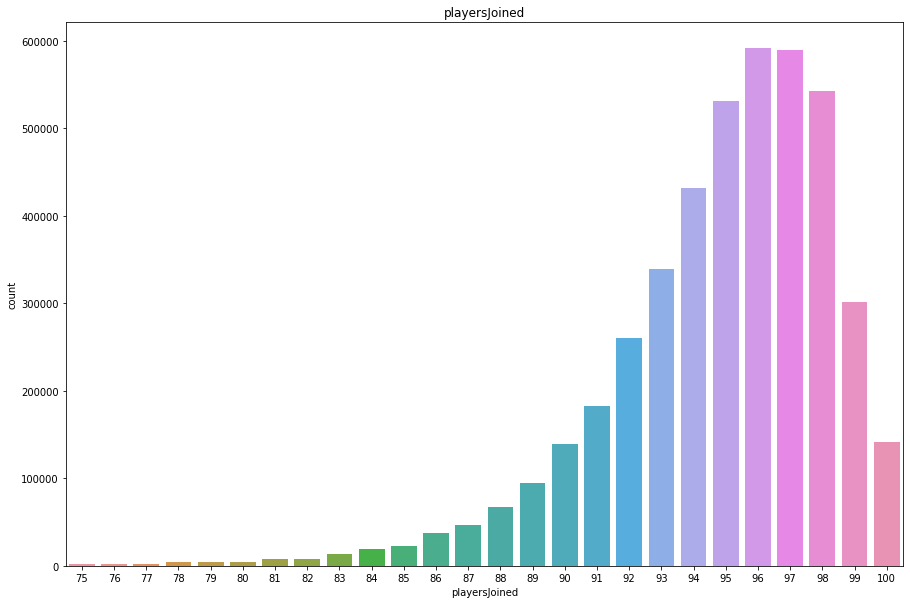

In [67]:
# playersJoined
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(train[train['playersJoined']>=75]['playersJoined'])
plt.title('playersJoined')
plt.show()

There are a few matches with fewer than 75 players that are not displayed here. As you can see most of the matches are nearly packed a have nearly 100 players. It is nevertheless interesting to take these features into our analysis.

> 有一些少于75人的比赛没有显示在这里。正如你所看到的，大部分的比赛几乎都挤满了人，有近100名球员。然而，在我们的分析中考虑这些feature是很有趣的。

### Normalized features

Now that we have a feature 'playersJoined' we can normalize other features based on the amount of players. Features that can be valuable to normalize are:
1. kills
2. damageDealt
3. maxPlace
4. matchDuration

Let's try out some things!

**Normalize features**

In [68]:
# Create normalized features
# 这里相当于对齐 train['kills'] * (100 - x) /100 +1，相当于加上少的那一部分
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersJoined'])/100 + 1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 + 1)
# Compare standard features and normalized features
to_show = ['Id', 'kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
train[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000000,0.000000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.470001,99.702301,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000000,69.360000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.900002,35.861002,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000000,103.000000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000000,105.000000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000000,0.000000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538000,8.879520,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.599998,53.147998,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.270000,38.388100,29,29.87,1930,1987.90


### Heals and Boosts

We create a feature called 'healsandboosts' by adding heals and boosts. (duh!) We are not sure if this has additional predictive value, but we can always delete it later if the feature importance according to our random forest model is too low.

> 我们创建了一个名为“healsandboost”的功能，heals + boosts。我们不确定它是否有效果，但如果根据我们的随机森林模型，特征重要性过低，我们总是可以在以后删除它。

In [69]:
# Create new feature healsandboosts
train['healsandboosts'] = train['heals'] + train['boosts']
train[['heals', 'boosts', 'healsandboosts']].tail()

,heals,boosts,healsandboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


### Killing without moving

We try to identify cheaters by checking if people are getting kills without moving. We first identify the totalDistance travelled by a player and then set a boolean value to True if someone got kills without moving a single inch. We will remove cheaters in our outlier detection section.

> 我们试图通过检查players是否在不动的情况下就能杀人。我们首先确定玩家的总行程，然后设置一个布尔值为真，如果有人在没有移动一英寸的情况下被杀死。我们将在离群点检测部分移除作弊者。

In [70]:
# Create feature totalDistance
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
# Create feature killsWithoutMoving
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

The feature headshot_rate will also help us to catch cheaters.

In [71]:
# Create headshot_rate feature
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

# Outlier Detection <a id="6"></a>

Some rows in our dataset have weird characteristics. The players could be cheaters, maniacs or just anomalies. Removing these outliers will likely improve results.

Inspiration for this section comes from [this amazing Kaggle Kernel.](https://www.kaggle.com/rejasupotaro/cheaters-and-zombies)

![Alt Text](https://media.giphy.com/media/OPRbXcsGctvZC/giphy.gif)

**Kills without movement**

This is perhaps the most obvious sign of cheating in the game. It is already fishy if a player hasn't moved during the whole game, but the player could be AFK and got killed. However, if the player managed to get kills without moving it is most likely a cheater.

In [72]:
# Check players who kills without moving
display(train[train['killsWithoutMoving'] == True].shape)
train[train['killsWithoutMoving'] == True].head(10)

(1535, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000000,0,0,3,18,...,0.8571,58,8.52,842.060000,21.30,842.06,3,0.0,True,0.000000
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.600006,0,0,6,33,...,0.6000,42,4.74,547.628010,17.38,2834.52,6,0.0,True,0.000000
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,...,0.8947,21,35.80,3132.500000,35.80,1607.42,5,0.0,True,0.200000
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.800003,0,0,0,69,...,0.0000,73,1.27,200.406004,24.13,1014.73,0,0.0,True,0.000000
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000000,0,1,0,37,...,0.3000,42,1.58,158.000000,17.38,2834.52,0,0.0,True,1.000000
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.100006,4,1,3,7,...,0.8000,44,9.36,789.516010,9.36,909.48,3,0.0,True,0.166667
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.000000,0,4,1,7,...,0.6000,48,18.24,1708.480000,9.12,836.00,1,0.0,True,0.333333
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.900024,0,2,11,12,...,0.8571,57,10.01,757.757035,21.45,856.57,11,0.0,True,0.285714
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.899994,0,1,6,53,...,0.2857,61,2.78,179.170992,11.12,1017.48,7,0.0,True,0.500000
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.559998,0,0,0,46,...,0.8571,53,1.47,125.773196,22.05,1051.05,0,0.0,True,0.000000


Got the suckers! 

In [73]:
# Remove outliers
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

**Anomalies in roadKills**

In [74]:
# Players who got more than 10 roadKills
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,...,0.4286,92,15.12,1345.68,99.36,1572.48,0,1282.302002,False,0.000000
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,...,0.4713,88,12.32,1234.24,98.56,2179.52,0,4934.600098,False,0.000000
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,...,1.0000,38,32.40,3359.88,61.56,3191.40,19,5876.000000,False,0.050000
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,...,0.9398,84,20.88,2164.56,97.44,2233.00,10,7853.000000,False,0.277778


In [75]:
# Drop roadKill 'cheaters'
train.drop(train[train['roadKills'] > 10].index, inplace=True)

Note that player c3e444f7d1289d drove 5 meters but killed 14 people with it. Sounds insane doesn't it?

![Alt Text](https://media.giphy.com/media/3o7aD85usFbbbrCR3i/giphy.gif)

**Anomalies in aim (More than 45 kills)**

Let's plot the total kills for every player first. It doesn't look like there are too many outliers.

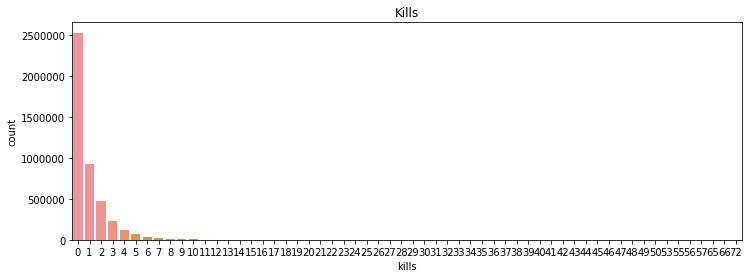

In [76]:
# Plot the distribution of kills
plt.figure(figsize=(12,4))
sns.countplot(data=train, x=train['kills']).set_title('Kills')
plt.show()

Let's take a closer look.

In [77]:
# Players who got more than 30 kills
display(train[train['kills'] > 30].shape)
train[train['kills'] > 30].head(10)

(95, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
57978,9d8253e21ccbbd,ef7135ed856cd8,37f05e2a01015f,9,0,3725.0,0,7,0,2,...,0.8571,16,64.40,6854.00,14.72,3308.32,0,48.820000,False,0.200000
87793,45f76442384931,b3627758941d34,37f05e2a01015f,8,0,3087.0,0,8,27,3,...,1.0000,16,57.04,5680.08,14.72,3308.32,27,780.700012,False,0.258065
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,...,0.7000,11,90.72,10355.31,20.79,3398.22,7,23.709999,False,0.250000
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,...,1.0000,62,57.96,5565.54,11.04,1164.72,0,718.299988,False,0.952381
180189,1355613d43e2d0,f863cd38c61dbf,39c442628f5df5,5,0,3171.0,0,6,15,1,...,1.0000,11,66.15,5993.19,17.01,3394.44,15,71.510002,False,0.171429
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,...,1.0000,11,122.85,12504.24,20.79,3398.22,5,1036.000000,False,0.200000
353128,f3e9746e3ff151,4bc1f00f07b304,a9e84c456cc859,2,0,3834.0,0,9,5,1,...,1.0000,13,72.93,7169.58,24.31,3356.65,5,124.199997,False,0.230769
457829,265e23756baa0b,9d94424171c2a1,664dee9ed8f646,3,0,2907.0,0,27,2,1,...,1.0000,38,53.46,4709.34,8.10,1339.74,2,382.399994,False,0.818182
488335,31a0682922ef45,275a27a3ee4cc8,3037f74ef8a3a3,2,0,3055.0,0,9,0,1,...,1.0000,20,59.40,5499.00,32.40,1605.60,0,35.299999,False,0.272727
662650,dd424a8b74bd49,ac9dea6d62f2e6,8a728def0644be,9,0,3454.0,38,9,4,1,...,0.2308,54,49.64,5042.84,20.44,1749.08,4,111.099998,False,0.264706


In [78]:
# Remove outliers
train.drop(train[train['kills'] > 30].index, inplace=True)

What do you think? Should we remove all these outliers from our dataset?

**Anomalies in aim part 2 (100% headshot rate)**

Again, we first take a look at the whole dataset and create a new feature 'headshot_rate'.
We see that the most players score in the 0 to 10% region. However, there are a few anomalies that have a headshot_rate of 100% percent with more than 9 kills!

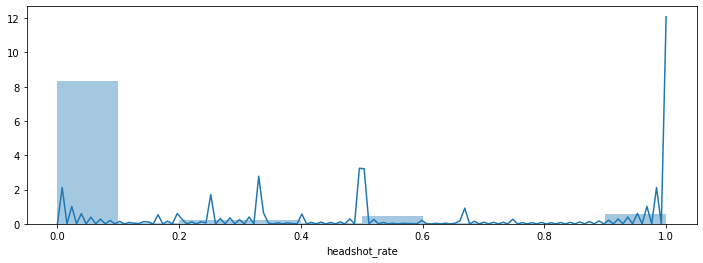

In [79]:
# Plot the distribution of headshot_rate
plt.figure(figsize=(12,4))
sns.distplot(train['headshot_rate'], bins=10)
plt.show()

In [80]:
# Players who made a minimum of 10 kills and have a headshot_rate of 100%
display(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape)
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].head(10)

(24, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,...,0.8462,93,10.70,1296.84,28.89,1522.61,3,2939.000000,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,...,1.0000,96,11.44,1684.80,28.08,1796.08,8,8142.000000,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,...,1.0000,98,13.26,1392.30,27.54,1280.10,4,2105.000000,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,...,0.9630,95,10.50,1611.75,29.40,1929.90,8,7948.000000,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,...,1.0000,96,10.40,1409.20,28.08,1473.68,8,3476.000000,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,...,1.0000,95,11.55,1278.90,29.40,1912.05,8,8178.000000,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,...,1.0000,97,10.30,1096.95,27.81,1283.38,5,2858.899902,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,...,1.0000,93,12.84,1411.33,29.96,1851.10,6,5963.000000,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,...,1.0000,88,12.32,1288.00,51.52,1397.76,5,3108.000000,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,...,1.0000,96,13.52,1537.12,50.96,1434.16,12,2479.800049,False,1.0


It is unclear if these players are cheating so we are probably not deleting these players from the dataset.
If they are legitimate players, they are probably really crushing the game!

![Alt Text](https://media.giphy.com/media/l3mZrOajz5VCZf7Hy/giphy.gif)


**Anomalies in aim part 3 (Longest kill)**

Most kills are made from a distance of 100 meters or closer. There are however some outliers who make a kill from more than 1km away. This is probably done by cheaters.

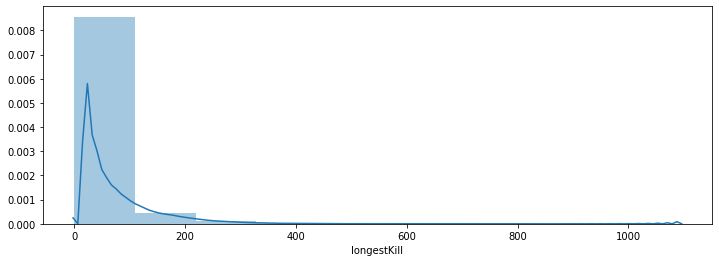

In [81]:
# Plot the distribution of longestKill
plt.figure(figsize=(12,4))
sns.distplot(train['longestKill'], bins=10)
plt.show()

Let's take a look at the players who make these shots.

In [82]:
# Check out players who made kills with a distance of more than 1 km
display(train[train['longestKill'] >= 1000].shape)
train[train['longestKill'] >= 1000].head(10)

(20, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.900024,5,1,1,5,...,0.9231,88,4.48,877.968027,30.24,2087.68,4,3775.199951,False,0.250000
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.000000,8,5,7,18,...,0.5385,29,18.81,2195.640000,23.94,2236.68,7,48.869999,False,0.454545
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.000000,0,0,0,9,...,1.0000,51,14.90,1531.720000,19.37,1040.02,0,2981.000000,False,0.000000
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.000000,17,5,0,3,...,0.6000,41,25.44,2241.900000,9.54,1734.69,0,29.209999,False,0.312500
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.800003,0,0,0,51,...,0.0000,61,1.39,273.552004,11.12,654.69,0,3159.000000,False,0.000000
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.000000,11,5,0,5,...,0.9091,86,11.40,1153.680000,13.68,1163.94,0,569.500000,False,0.500000
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.299988,0,0,2,45,...,0.2857,58,4.26,467.605983,11.36,825.02,3,832.500000,False,0.000000
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.000000,0,7,0,1,...,0.9412,52,22.20,2427.200000,76.96,1827.80,6,2848.000000,False,0.466667
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.000000,0,4,11,11,...,0.5000,28,39.56,3617.160000,25.80,3092.56,13,235.300003,False,0.173913
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.000000,0,6,5,15,...,0.6000,42,17.38,2057.160000,17.38,2834.52,8,133.199997,False,0.545455


In [83]:
# Remove outliers
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

There is something fishy going on with these players. We are probably better off removing them from our dataset.

![Alt Text](https://media.giphy.com/media/RHJkLqcdvMQF4GI3P7/giphy.gif)

**Anomalies in travelling (rideDistance, walkDistance and swimDistance)**

Let's check out anomalies in Distance travelled.

In [84]:
# Summary statistics for the Distance features
train[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4.445311e+06,4.445311e+06,4.445311e+06,4.445311e+06
mean,1.148926e+03,6.063038e+02,4.510894e+00,1.755305e+03
std,1.180588e+03,1.496642e+03,3.024322e+01,2.175305e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00,1.584000e+02
50%,6.864000e+02,0.000000e+00,0.000000e+00,7.893000e+02
75%,1.977000e+03,2.606500e-01,0.000000e+00,2.729000e+03
max,2.578000e+04,4.071000e+04,3.823000e+03,4.127010e+04


**walkDistance**

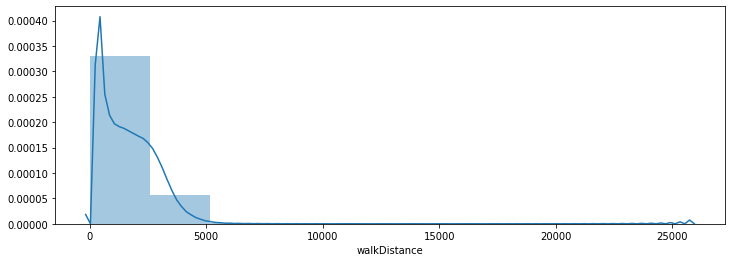

In [85]:
# Plot the distribution of walkDistance
plt.figure(figsize=(12,4))
sns.distplot(train['walkDistance'], bins=10)
plt.show()

In [86]:
# walkDistance anomalies
display(train[train['walkDistance'] >= 10000].shape)
train[train['walkDistance'] >= 10000].head(10)

(219, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.000000,0,0,0,44,...,0.8163,99,0.00,0.000000,99.99,1925.06,1,13540.302734,False,0.0
34344,5a591ecc957393,6717370b51c247,a15d93e7165b05,0,3,23.219999,0,0,1,34,...,0.9474,65,0.00,31.346999,27.00,2668.95,4,10070.907227,False,0.0
49312,582685f487f0b4,338112cd12f1e7,d0afbf5c3a6dc9,0,4,117.199997,1,0,1,24,...,0.9130,94,1.06,124.231997,49.82,2323.52,5,12446.758789,False,0.0
68590,8c0d9dd0b4463c,c963553dc937e9,926681ea721a47,0,1,32.340000,0,0,1,46,...,0.8333,96,0.00,33.633600,50.96,1909.44,2,12483.620117,False,0.0
94400,d441bebd01db61,7e179b3366adb8,923b57b8b834cc,1,1,73.080002,0,0,3,27,...,0.8194,73,0.00,92.811602,92.71,2293.62,4,11490.629883,False,0.0
125103,db5a0cdc969dcb,50cc466757950e,c306a9745c4c1d,0,4,37.730000,0,0,7,47,...,0.7340,95,0.00,39.616500,99.75,2054.85,11,12828.797852,False,0.0
136421,955e60b09a96b1,30df08fe22a901,8669d01725f135,0,1,0.000000,0,0,1,46,...,0.6957,94,0.00,0.000000,49.82,2091.38,2,12223.809570,False,0.0
136476,0d75d05b5c988c,3da040ce77cd0b,65bc5211a569dd,0,3,0.000000,0,0,0,41,...,0.9333,91,0.00,0.000000,99.19,2028.49,3,14918.200195,False,0.0
154080,7e8a71d23381cd,e2c9f4f92840b2,a721de1aa05408,0,3,0.000000,0,0,13,46,...,0.8602,94,0.00,0.000000,99.64,2038.38,16,12636.700195,False,0.0
154128,32fdde4c716787,390ae9a51c11b8,82610ed1b4d033,0,4,52.160000,0,0,7,25,...,0.8936,95,1.05,54.768000,50.40,1927.80,11,10889.861328,False,0.0


In [87]:
# Remove outliers
train.drop(train[train['walkDistance'] >= 10000].index, inplace=True)

**rideDistance**

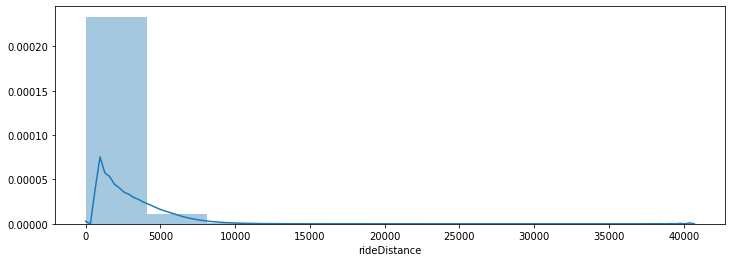

In [88]:
# Plot the distribution of rideDistance
plt.figure(figsize=(12,4))
sns.distplot(train['rideDistance'], bins=10)
plt.show()

In [89]:
# rideDistance anomalies
display(train[train['rideDistance'] >= 20000].shape)
train[train['rideDistance'] >= 20000].head(10)

(150, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
28588,6260f7c49dc16f,b24589f02eedd7,6ebea3b4f55b4a,0,0,99.199997,0,0,1,30,...,0.6421,96,1.04,103.167997,99.84,1969.76,1,26306.599609,False,0.000000
63015,adb7dae4d0c10a,8ede98a241f30a,8b36eac66378e4,0,0,0.000000,0,0,0,55,...,0.5376,94,0.00,0.000000,99.64,2004.46,0,22065.400391,False,0.000000
70507,ca6fa339064d67,f7bb2e30c3461f,3bfd8d66edbeff,0,0,100.000000,0,0,0,26,...,0.8878,99,1.01,101.000000,99.99,1947.28,0,28917.500000,False,0.000000
72763,198e5894e68ff4,ccf47c82abb11f,d92bf8e696b61d,0,0,0.000000,0,0,0,46,...,0.7917,97,0.00,0.000000,99.91,1861.21,0,21197.199219,False,0.000000
95276,c3fabfce7589ae,15529e25aa4a74,d055504340e5f4,0,7,778.200012,0,1,2,2,...,0.9785,94,7.42,824.892013,99.64,1986.44,9,26733.199219,False,0.142857
140097,9944fbbea2b91e,18b4d5f4bb1906,d9d4a3e50cae75,1,0,12.550000,0,0,0,53,...,0.5000,89,0.00,13.930500,98.79,2107.89,0,21293.230469,False,0.000000
297186,88904c200175b6,012a61a01e146e,7a270c25e9b70c,0,1,0.000000,0,0,1,47,...,0.7447,96,0.00,0.000000,49.92,1995.76,2,29267.300781,False,0.000000
371098,f7071357f6b762,f3ee20821f4627,ac47c86bf385bf,0,0,72.919998,1,0,0,45,...,0.6875,96,0.00,75.836798,50.96,1953.12,0,21942.099609,False,0.000000
403647,c65da7b3fceef5,814d1b3736e276,ff9f570b555d48,0,2,0.000000,0,0,3,54,...,0.6739,94,0.00,0.000000,49.82,1930.26,5,21198.199219,False,0.000000
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.000000,0,0,2,43,...,0.8171,83,0.00,0.000000,97.11,2348.19,4,32362.099609,False,0.000000


In [90]:
# Remove outliers
train.drop(train[train['rideDistance'] >= 20000].index, inplace=True)

Cheaters or do they just like to ride like these guys?

![Alt Text](https://media.giphy.com/media/qlCFjkSruesco/giphy.gif)

**swimDistance**

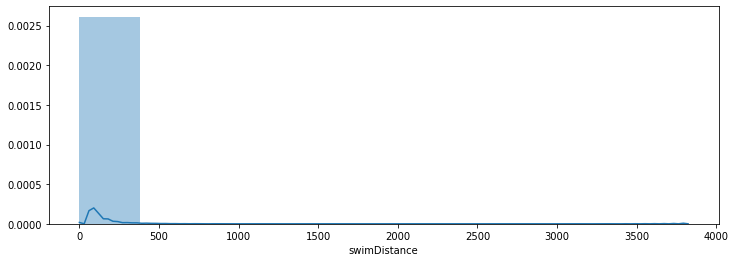

In [91]:
# Plot the distribution of swimDistance
plt.figure(figsize=(12,4))
sns.distplot(train['swimDistance'], bins=10)
plt.show()

In [92]:
# Players who swam more than 2 km
train[train['swimDistance'] >= 2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.120003,1,0,1,47,...,0.9592,98,0.00,79.682403,51.00,1426.98,6,3297.000000,False,0.000000
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.320000,0,0,16,39,...,0.9600,94,0.00,56.519200,27.56,2319.28,20,10113.000000,False,0.000000
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.000000,4,3,1,6,...,1.0000,88,3.36,563.360000,29.12,2124.64,2,10740.000000,False,1.000000
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.299988,3,1,6,4,...,1.0000,98,5.10,359.345988,49.98,1423.92,13,3083.100098,False,0.200000
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.200012,3,1,1,46,...,1.0000,86,2.28,671.688014,13.68,1163.94,2,4818.299805,False,0.500000
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.000000,0,0,0,47,...,0.5833,87,0.00,0.000000,28.25,1567.31,0,5314.000000,False,0.000000
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.590000,0,0,5,48,...,0.8511,96,0.00,51.573600,49.92,1434.16,8,9899.000000,False,0.000000
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.399994,2,0,0,7,...,1.0000,91,3.27,517.095993,29.43,1318.90,1,2394.545898,False,0.000000
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,843.799988,5,5,2,2,...,0.9600,94,7.42,894.427987,27.56,2319.28,6,9926.000000,False,0.714286
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.000000,0,0,0,77,...,0.2143,96,0.00,0.000000,30.16,1426.88,0,4088.000000,False,0.000000


In [93]:
# Remove outliers
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

Do you think these guys are legit?

![Alt Text](https://thumbs.gfycat.com/EvenSpiffyFerret-size_restricted.gif)

**Anomalies in supplies (weaponsAcquired)**

Most people acquire between 0 and 10 weapons in a game, but you also see some people acquire more than 80 weapons! Let's check these guys out.

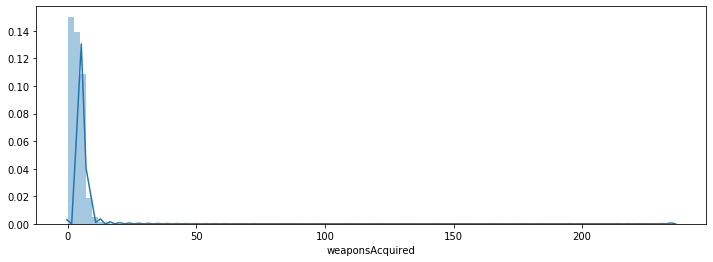

In [94]:
# Plot the distribution of weaponsAcquired
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=100)
plt.show()

In [95]:
# Players who acquired more than 80 weapons
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()

(19, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.110001,0,0,0,44,...,0.7111,91,0.00,73.149901,50.14,2072.09,0,3187.000000,False,0.000000
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.300003,1,0,2,48,...,0.7500,98,0.00,178.806003,29.58,1399.44,3,1687.000000,False,0.000000
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.000000,0,0,0,24,...,0.8929,97,1.03,103.000000,29.87,1895.20,0,5299.209961,False,0.000000
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.000000,0,0,0,54,...,0.5600,80,0.00,0.000000,31.20,1596.00,0,653.099976,False,0.000000
1592744,634a224c53444e,75fa7591d1538c,f900de1ec39fa5,9,0,1726.000000,0,3,0,9,...,0.2000,11,43.47,3262.140000,20.79,3398.22,0,2888.800049,False,0.130435


In [96]:
# Remove outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

We should probably remove these outliers from our model. Do you agree?

Note that player 3f2bcf53b108c4 acquired 236 weapons in one game!

![Alt Text](https://media.giphy.com/media/69lWR6c8Afx9qeg2Tu/giphy.gif)

**Anomalies in supplies part 2 (heals)**

Most players us 5 healing items or less. We can again recognize some weird anomalies

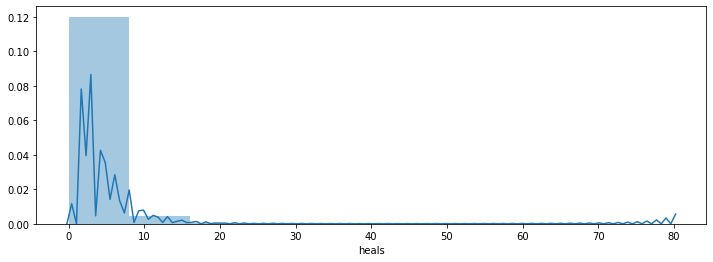

In [97]:
# Distribution of heals
plt.figure(figsize=(12,4))
sns.distplot(train['heals'], bins=10)
plt.show()

In [98]:
# 40 or more healing items used
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)

(135, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,...,0.9368,96,0.00,0.00,99.84,1868.88,49,6854.000000,False,0.000000
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,...,0.9615,93,1.07,194.74,28.89,1639.24,47,3083.399902,False,1.000000
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,...,0.8333,97,0.00,0.00,99.91,1415.22,54,1343.442993,False,0.000000
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,...,0.8646,97,0.00,0.00,99.91,1822.07,52,7444.000000,False,0.000000
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,...,0.8370,93,0.00,0.00,99.51,2009.46,53,5816.000000,False,0.000000
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,...,0.9259,97,0.00,0.00,28.84,1333.85,44,2439.000000,False,0.000000
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,...,0.8276,99,0.00,124.23,30.30,1984.65,43,4848.000000,False,0.000000
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,...,0.9355,95,1.05,183.75,33.60,1425.90,53,3415.600098,False,1.000000
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,...,0.8889,41,42.93,3733.32,58.83,2857.23,41,268.799988,False,0.296296
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,...,0.9630,94,4.24,295.21,29.68,1915.42,51,4927.000000,False,0.250000


In [99]:
# Remove outliers
train.drop(train[train['heals'] >= 40].index, inplace=True)

**Outlier conclusions**

We removed about 2000 players from our dataset. Do you think this is too much? Please let us know in the comments.

In [100]:
# Remaining players in the training set
train.shape

(4444776, 38)

# Categorical Variables <a id="7"></a>

We will one hot encode the 'matchType' feature to use it in our Random Forest model.

In [101]:
print('There are {} different Match types in the dataset.'.format(train['matchType'].nunique()))

There are 16 different Match types in the dataset.


In [102]:
# One hot encode matchType
train = pd.get_dummies(train, columns=['matchType'])

# Take a look at the encoding
matchType_encoding = train.filter(regex='matchType')
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


There are a lot of groupId's and matchId's so one-hot encoding them is computational suicide.
We will turn them into category codes. That way we can still benefit from correlations between groups and matches in our Random Forest algorithm.

In [103]:
# Turn groupId and match Id into categorical types
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

# Get category coding for groupId and matchID
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

# Get rid of old columns
train.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613591,30085
1,827582,32751
2,843273,3143
3,1340072,45260
4,1757338,20531


In [104]:
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
train.drop(columns = ['Id'], inplace=True)

**voilà!**

# Preparation for Machine Learning <a id="8"></a>

## Sampling

We will take a sample of 500000 rows from our training set for easy debugging and exploration.

In [105]:
# Take sample for debugging and exploration
sample = 500000
df_sample = train.sample(sample)

## Split target variable, validation data, etc.

In [106]:
# Split sample into training data and target variable
df = df_sample.drop(columns = ['winPlacePerc']) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable

In [ ]:
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# Check dimensions of samples
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

## Set metrics (MAE)

[Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) is the metric that is used for this competition. The scikit-learn library already programmed this metric for us so we don't have to implement it from scratch.

In [ ]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE (Mean Absolute Error) score
# This is the metric used by Kaggle in this competition
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## First basic Random Forest Model

In [ ]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

# Feature Importance <a id="9"></a>

The [fastai](https://www.fast.ai/) library gives us an easy way to analyze feature importances from a random forest algorithm with just one line of code!

In [ ]:
# What are the most predictive features according to our basic random forest model
fi = rf_feat_importance(m1, df); fi[:10]

In [ ]:
# Plot a feature importance graph for the 20 most important features
plot1 = fi[:20].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

In [ ]:
# Use this code if you want to save the figure
#fig = plot1.get_figure()
#fig.savefig("Feature_importances(AllFeatures).png")

In [ ]:
# Keep only significant features
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

In [ ]:
# Make a DataFrame with only significant features
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

## Second Random Forest Model

This time we use only the top features to train a random forest model. This often improves results a little bit.

In [ ]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

**Feature importance for top features**

In [ ]:
# Get feature importances of our top features
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

# Use this code if you want to save the figure
#fig = plot2.get_figure()
#fig.savefig("Feature_importances(TopFeatures).png")

## Correlations

**Dendrogram (to view correlation of features)**

In [ ]:
# Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.plot()

In [ ]:
# Use this code if you want to save the figure
#plt.savefig('Dendrogram.png')

**Correlation Heatmap**

In [ ]:
# Correlation heatmap
corr = df_keep.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Create heatmap
heatmap = sns.heatmap(corr)

In [ ]:
# Use this code if you want to save the figure
#fig = heatmap.get_figure()
#fig.savefig("Heatmap(TopFeatures).png")

**Predictive quality of kills**

In [ ]:
# Plot the predictive quality of kills 
x_all = get_sample(train, 100000)
ggplot(x_all, aes('kills','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

**Predictive quality of walkDistance**

In [ ]:
# Plot the predictive quality of walkDistance
x_all = get_sample(train, 100000)
ggplot(x_all, aes('walkDistance','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

# Final Random Forest Model <a id="10"></a>

In [ ]:
# Prepare data
val_perc_full = 0.12 # % to use for validation set
n_valid_full = int(val_perc_full * len(train)) 
n_trn_full = len(train)-n_valid_full
df_full = train.drop(columns = ['winPlacePerc']) # all columns except target
y = train['winPlacePerc'] # target variable
df_full = df_full[to_keep] # Keep only relevant features
X_train, X_valid = split_vals(df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)

# Check dimensions of data
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

In [ ]:
# Train final model
# You should get better results by increasing n_estimators
# and by playing around with the parameters
m3 = RandomForestRegressor(n_estimators=70, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)

# Kaggle Submission <a id="11"></a>

In [ ]:
# Add engineered features to the test set
test['headshot_rate'] = test['headshotKills'] / test['kills']
test['headshot_rate'] = test['headshot_rate'].fillna(0)
test['totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['killsNorm'] = test['kills']*((100-test['playersJoined'])/100 + 1)
test['damageDealtNorm'] = test['damageDealt']*((100-test['playersJoined'])/100 + 1)
test['maxPlaceNorm'] = test['maxPlace']*((100-train['playersJoined'])/100 + 1)
test['matchDurationNorm'] = test['matchDuration']*((100-test['playersJoined'])/100 + 1)
test['healsandboosts'] = test['heals'] + test['boosts']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['totalDistance'] == 0))

# Turn groupId and match Id into categorical types
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

# Remove irrelevant features from the test set
test_pred = test[to_keep].copy()

# Fill NaN with 0 (temporary)
test_pred.fillna(0, inplace=True)
test_pred.head()

In [ ]:
# Make submission ready for Kaggle
# We use our final Random Forest model (m3) to get the predictions
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})

# Create submission file
pred_df.to_csv("submission.csv", index=False)

**Check of submission file**

It is always nice to take a look at few of your predictions to make sure that the structure is right for a Kaggle submission.

In [ ]:
# Last check of submission
print('Head of submission: ')
display(pred_df.head())
print('Tail of submission: ')
display(pred_df.tail())